# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [248]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# for text cleaning
import re # regular expression 
import string
# draw plot here
%matplotlib inline 

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02


In [205]:
help(BinaryClassificationPerformance)


Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [288]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t') #fn filename  
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    
    if (not test): 
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean()) # good 1 - bad 0

    # word and punctuation count, before cleaning     
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")        

    ## Text Cleaning ##   
    # lowercase, remove text inside < >, remove punctuation - call cleaning
    def initial_cleaning(t):
            t = t.lower()
            t = re.sub('\<.*?\>', '', t) 
            t = re.sub('[%s]' % re.escape(string.punctuation), '', t) 
            return t      
    movie_data.review = movie_data.review.apply(lambda x: initial_cleaning(str(x)))
    # stop words manual set up - count - remove
    eng_stop = ["i", "ive", "im", "id", "me", "my", "myself", "we", "weve", "were", "our", "ours", "ourselves", "you", "youve", "youre","youd", "your", "yours", "yourself", "yourselves", "he", "hes", "hed", "him", "his", "himself", "she", "shes", "her", "hers", "herself", "it", "its", "itself", "they", "theyre", "theyve","them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
    movie_data['stop_count'] = movie_data['review'].apply(lambda x: len([x for x in x.split() if x in eng_stop]))      
    movie_data['review'] = movie_data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in eng_stop)) 
    # newly calculated word count
    movie_data['remainders_count'] = movie_data['review'].str.split(' ').str.len()
    # Check some review data here 
    print("Sample of clean movie_data review: ")
    print (movie_data.review.sample(n=3, random_state=10))

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 18, alternate_sign=False)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    # already normalized
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features to add to feature set
    # got rid of "word_count", "punc_count", "stop_count",  
    X_quant_features = movie_data[["remainders_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features) # csr - Compressed Sparse Row matrix
    X_combined = hstack([X_tfidf, X_quant_features_csr]) # hstack - Stack sparse matrices horizontally (column wise)
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [289]:
# CHANGED FILE PATH and my_random_seed number : 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/moviereviews_train.tsv', my_random_seed=99)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [266]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 5168, 'TN': 4904, 'FP': 5108, 'FN': 4820, 'Accuracy': 0.5036, 'Precision': 0.5029194239003504, 'Recall': 0.5174209050861033, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [290]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [302]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', max_iter=10000, alpha=0.001)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [292]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9860, 'TN': 9947, 'FP': 65, 'FN': 128, 'Accuracy': 0.99035, 'Precision': 0.9934508816120907, 'Recall': 0.9871846215458551, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [303]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [304]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=0.0001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9988, 'Neg': 10012, 'TP': 9988, 'TN': 10012, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [305]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/inhyelee/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9988, 'Neg': 10012, 'TP': 4323, 'TN': 7521, 'FP': 2491, 'FN': 5665, 'Accuracy': 0.5922, 'Precision': 0.6344291165248018, 'Recall': 0.43281938325991187, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

-SVM-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Logistic-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Naive Bayes-
True Positive rate: 
0.9871846215458551
False Positive rate: 
0.0064922093487814626
-Perceptron-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Ridge R-
True Positive rate: 
1.0
False Positive rate: 
0.0
-Random Forest-
True Positive rate: 
0.43281938325991187
False Positive rate: 
0.2488014382740711


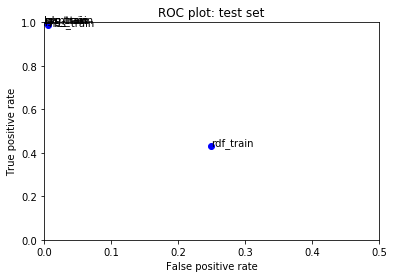

In [318]:
# Removed are ols_performance_train
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits_name = ["-SVM-", "-Logistic-", "-Naive Bayes-", "-Perceptron-", "-Ridge R-", "-Random Forest-"]
for i, fit in enumerate(fits): 
    TP_POS_rate = fit.performance_measures['TP'] / fit.performance_measures['Pos']
    FP_NEG_rate = fit.performance_measures['FP'] / fit.performance_measures['Neg']
    # print in numbers 
    print(fits_name[i])
    print("True Positive rate: ")
    print(TP_POS_rate)
    print("False Positive rate: ")
    print(FP_NEG_rate)
    # plt
    plt.plot(FP_NEG_rate, TP_POS_rate, 'bo')
    plt.text(FP_NEG_rate, TP_POS_rate, fit.desc)
# draw
plt.axis([0, 0.5, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()



### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [237]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [238]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
2
first saw movie 7 years old christian scholl attended needless say scared mind scary contentcmoni 7 anyway cinematography pretty bad acting cheesy thats bad considering 7 remember one thing still haunts dreadful song wish ready chorus ends left behind wouldnt suggest seeing one probably nostalgic reason besides sure remake much better best part movie though everyone dissapears vacant cars crashing lawnmowers running ownpretty hilarious
* * * * * * * * * 
26
strained comedy sketchlike revue initially vehicle showcase onetime radio star jack pearl best remembered americas introduction three stooges actually larry curly moe billed alongside comic ted healy ted healy three stooges although supporting cast features jimmy durante completely wasted dim material zasu pitts audience film days stoogesaddicts even wont find much applaud incredibly loud overbearing shows far hollywood go reach certain level slapstick sophistication 12
* * * * * * * * * 
94
feel much 

3733
show comes interesting locations fast travel channel billed reality actuality pure prime time soap opera tries use exotic locales facade bring people phony contest proceeds hook viewers contestants soap opera styleit also borrows early cbs game show pioneer beat clock inventing situations contestants try overcome rewards winner money spice little interaction characters even better game format slow motion versus beat clock real accomplishment series escape reality show elements several types successful past programs reality television hardly hooked contestants locale contest cup tea entire series say drivel dripping gravy another show hiding behind reality label trend started 2000it slick well produced might last yet reruns gilligans island green acres beverly hillbillies brady bunch doesnt employ professional actors intelligence level
* * * * * * * * * 
3860
often feel compelled give negative criticism film often feel maxim dont anything good say dont say would apt advice many nay

6902
couldnt believe lame pointless basically nothing laugh movie hardly scenes get interested rest movie movie pulled huge stars wasted opinion think keanu reeves mustve taken acting lessons fews years movie stared matrix uma thurman looked simple humble luckily got movie low price certainly movie remember good reasons wont write anything story movie know meant famous hitchhiker across america huge thumb would give movie 2 10 watched movie wondering movie got 4010 know disappointing movie dont buy even see 5
* * * * * * * * * 
7013
always felt good film plot particular film missing one feel would effective plot made even worse fact seemed go forever anxious finally end however noticed 123 minutes long felt like four hours plot film also lacked notable conflict worst movie seen used say saw fast furious dont think review mine someone needs nothing action actually hate action films today film way side spectrum much really happens movie however scenery costumes nice
* * * * * * * * * 
71

10386
cannot believe guy directed crap dracula 2000 dracula 2000 innovative fresh well written poorly actedthis pile cant even claim starts defeat dracula end dracula 2000 ignores narrative afterwards describing happened following narrative properly could made good sequel somehow craven chose go style older films good tie main villains nameeven actor playing dracula different going dark hair dracula 2000 blonde hereavoid movie respect taste movies
* * * * * * * * * 
10418
liked first two films sorry say going like one really rubbish unnecessary straight video probably tv made sequel still idiotic nice scientist wayne szalinski rick moranis still living family company szalinski inc unfortunately wife wants get rid statue wayne stupid shrinks statue brother shrinks wife sisterinlaw adults find way get kids house get bigger pretty much repeat two one two new things eg toy car roller coaster swimming dip etc pretty poor
* * * * * * * * * 
10555
friday 13th step officially worse movie hatef

13749
low budget b horrors plot comes amenities mad scientist complete sidekick malicious corporate greed pharmaceutical industry eccentric extreme genetic engineering information technologycant leave outstart strange sequence hot looking nameless boaters foolishly decide take dip waters near uncharted island end chum swarming hammerhead sharkscut weak back story implying stock decline generic pharma corporation motivates wicked shakespeare quoting ceo entertain unsolicited offer made former employeescientist jilted job head research also happens nutof course total herbert west wannabe offering new stem cell technology could make tons o cashor seemsthis lures several employees moreauish island must quite impressive exit package company let go afford island validate scientific findings including ceo coincidentally exfiancé mad scientists son morphed sharkuman convenientthe plan sort rekindle lost love former nuptials exacting revenge former colleagues termination sheez guy bitter frigge

17123
stopped bb picked 4 zombie flicks watch weekend understand effects cheesy acting subpar sets suspect expecting much least story stories dont cost thing except timeapparently didnt time eitherzombie nation 5 zombies appeared near end movie looked like new wave hookers picture zombie front cover never appears movie absolutely agonizing watch nothing offer genrethe running time 81 minutes felt like 2 hours according wife could hear movie since computer another room sounded like zombie pornwhich think sounds kinda grossbut wasnt even goodthe suggestion make maybe writer tried many things ended incoherent messit ended free rental still feel ripped rated 1 10 imdb wont allow use decimals
* * * * * * * * * 
17158
amateur budget films surprisingly good however one themah another brad sykes atrocity acting hideous except emmy smith shows promise camera direction needs serious reworking hold camera run gimmicks either doesnt work special effects unimaginative theres problem effect identifi

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [319]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 1360, 'TN': 1240, 'FP': 1248, 'FN': 1152, 'Accuracy': 0.52, 'Precision': 0.5214723926380368, 'Recall': 0.5414012738853503, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [320]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2055, 'TN': 2047, 'FP': 441, 'FN': 457, 'Accuracy': 0.8204, 'Precision': 0.8233173076923077, 'Recall': 0.8180732484076433, 'desc': 'svm_test'}


### MODEL: logistic regression

In [321]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2088, 'TN': 2009, 'FP': 479, 'FN': 424, 'Accuracy': 0.8194, 'Precision': 0.8134008570315543, 'Recall': 0.8312101910828026, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [322]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 1780, 'TN': 1717, 'FP': 771, 'FN': 732, 'Accuracy': 0.6994, 'Precision': 0.697765582124657, 'Recall': 0.7085987261146497, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [323]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2080, 'TN': 2004, 'FP': 484, 'FN': 432, 'Accuracy': 0.8168, 'Precision': 0.8112324492979719, 'Recall': 0.8280254777070064, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [324]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 2194, 'TN': 2138, 'FP': 350, 'FN': 318, 'Accuracy': 0.8664, 'Precision': 0.8624213836477987, 'Recall': 0.8734076433121019, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [325]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2512, 'Neg': 2488, 'TP': 1109, 'TN': 1891, 'FP': 597, 'FN': 1403, 'Accuracy': 0.6, 'Precision': 0.6500586166471278, 'Recall': 0.44148089171974525, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

-SVM-
True Positive rate: 
0.8180732484076433
False Positive rate: 
0.1772508038585209
-Logistic-
True Positive rate: 
0.8312101910828026
False Positive rate: 
0.192524115755627
-Naive Bayes-
True Positive rate: 
0.7085987261146497
False Positive rate: 
0.30988745980707394
-Perceptron-
True Positive rate: 
0.8280254777070064
False Positive rate: 
0.1945337620578778
-Ridge R-
True Positive rate: 
0.8734076433121019
False Positive rate: 
0.14067524115755628
-Random Forest-
True Positive rate: 
0.44148089171974525
False Positive rate: 
0.23995176848874597


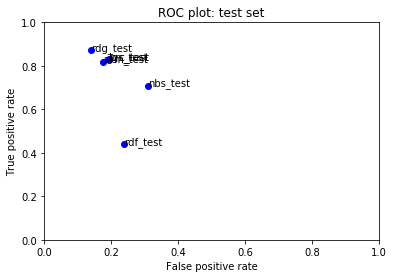

In [328]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
fits_name = ["-SVM-", "-Logistic-", "-Naive Bayes-", "-Perceptron-", "-Ridge R-", "-Random Forest-"]
for i, fit in enumerate(fits): 
    TP_POS_rate = fit.performance_measures['TP'] / fit.performance_measures['Pos']
    FP_NEG_rate = fit.performance_measures['FP'] / fit.performance_measures['Neg']
    # print in numbers 
    print(fits_name[i])
    print("True Positive rate: ")
    print(TP_POS_rate)
    print("False Positive rate: ")
    print(FP_NEG_rate)
    # plt
    plt.plot(FP_NEG_rate, TP_POS_rate, 'bo')
    plt.text(FP_NEG_rate, TP_POS_rate, fit.desc)
# draw
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [329]:
# read in test data for submission
# CHANGED - FILE PATH and my_random_seed number:  
raw_data, X_test_submission = process_raw_data(fn='../final_data/moviereviews_test.tsv', my_random_seed=99, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
5    2913_8  ...as valuable as King Tut's tomb! (OK, maybe ...
6    4396_1  This has to be one of the biggest misfires eve...
7     395_2  This is one of those movies I watched, and won...
8   10616_1  The worst movie i've seen in years (and i've s...
9    9074_9  Five medical students (Kevin Bacon, David Labr...
Sample of clean movie_data review: 
18634    one beautifully morbid films e

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! -> Choosing ridge regression

In [330]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
# ridge regression selected
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49944


In [335]:
raw_data.head(10)

,id,review,word_count,punc_count,stop_count,remainders_count
0,12311_10,naturally film whos main themes mortality nost...,131,5,58,73
1,8348_2,movie disaster within disaster film full great...,169,15,82,84
2,5828_4,movie kids saw tonight child loved one point k...,176,18,89,83
3,7186_2,afraid dark left impression several different ...,112,5,54,53
4,12128_7,accurate depiction small time mob life filmed ...,133,8,53,76
5,2913_8,valuable king tuts tomb ok maybe valuable wort...,331,20,164,164
6,4396_1,one biggest misfires everthe script nice could...,121,18,54,60
7,395_2,one movies watched wondered watch find interes...,230,22,109,115
8,10616_1,worst movie seen years seen lot movies acting ...,59,3,29,29
9,9074_9,five medical students kevin bacon david labrac...,224,14,70,144


In [336]:
my_submission.head(10)

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,1
4,12128_7,1
5,2913_8,1
6,4396_1,0
7,395_2,0
8,10616_1,0
9,9074_9,0


In [333]:
my_submission.shape

(25000, 2)

In [334]:
# export submission file as csv
# CHANGE FILE PATH: 
my_submission.to_csv('../final_data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation